## Data loading

In [1]:
# Load data and packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

directory_path = os.getcwd() + "\\Data\\sorting_event_volumes_2023.csv"

df = pd.read_csv(directory_path)

## Data cleaning

In [2]:
# Data cleaning
print("Number of rows original dataset is: " + str(df.shape[0]))

df = df.loc[df["event_type"] == "LAJ", :]
df.drop(['event_location', 'input_belt', 'position'], axis=1, inplace = True)
df.dropna(inplace = True)
df['output_belt'] = df['output_belt'].astype(int)
df = df.groupby(['sorting_center_name', 'scanning_date', 'output_belt'], as_index = False)['no_of_events'].sum()
df['scanning_date'] = pd.to_datetime(df['scanning_date'])

print("Number of rows cleaned dataset is: " + str(df.shape[0]))

Number of rows original dataset is: 8949721
Number of rows cleaned dataset is: 188628


## Data preparation

In [3]:
# Data preparation
df['day'] = df['scanning_date'].dt.day
df['month'] = df['scanning_date'].dt.month
df['weekday'] = df['scanning_date'].dt.day_of_week + 1
df['week'] = df['scanning_date'].dt.day_of_year // 7 + 1

sorting_center_names = df["sorting_center_name"].unique()
df["sorting_center_name"].value_counts()
print(sorting_center_names)

['KUOPIO' 'LIETO' 'OULU' 'SEINÄJOKI' 'TAMPERE' 'VANTAA']


## Descriptive statistics

In [4]:
# Descriptive statistics (Jelmer)

## Data visualizations

### Aggregate demand planning horizon

In [5]:
# Aggregate demand planning horizon (Mats)

### Boxplots

In [6]:
# Boxplots (Jelmer)

# Yearly

# Monthly

# Weekday

# Yearly per sorting center

### Day of the month

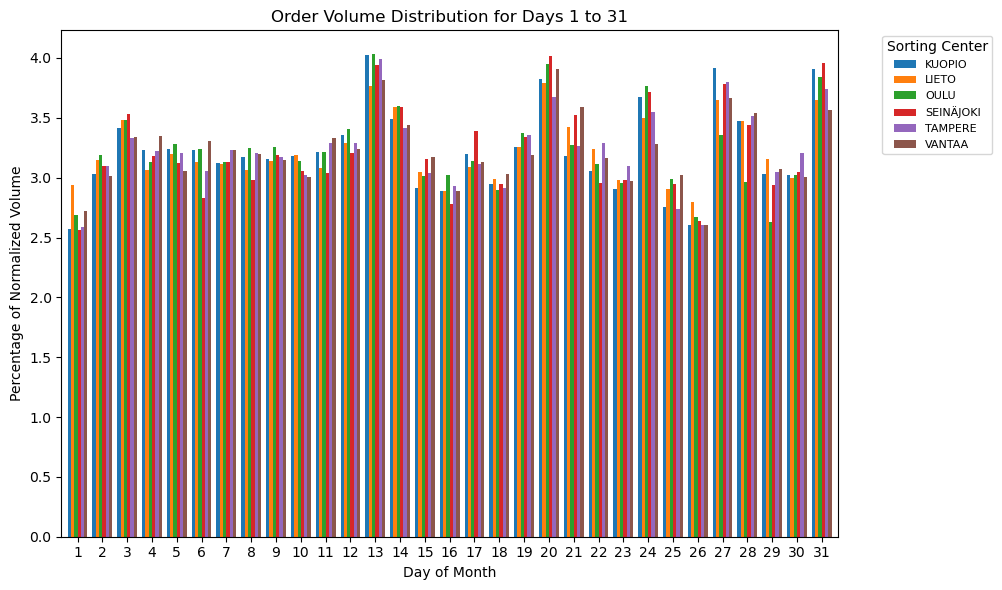

In [7]:
# Day of the month (Sun)

# Define the number of valid months for each day of the month
# Days 1-28 appear in all 12 months, day 29 appears in 11 months (February excluded),
# day 30 appears in 11 months (February excluded), and day 31 appears in only 7 months
# (months missing the 31st: April, June, September, November).
valid_months = {day: 12 for day in range(1, 29)}  # Days 1-28 in all 12 months
valid_months[29] = 11  # Day 29 appears in 11 months
valid_months[30] = 11  # Day 30 appears in 11 months
valid_months[31] = 7   # Day 31 appears in 7 months

# Create an empty DataFrame to store the results for each sorting center
result = pd.DataFrame()

# Get the list of unique sorting centers from the dataset
sorting_centers = df['sorting_center_name'].unique()

# For each sorting center, calculate the normalized order volume percentage
for center in sorting_centers:
    # Filter the data for the current sorting center
    center_data = df[df['sorting_center_name'] == center]

    # Group the data by day of the month and sum the total number of events (orders)
    daily_volume = center_data.groupby('day')['no_of_events'].sum()
    # Normalize the daily volume by dividing by the number of months in which each day exists
    # This adjusts for the fact that not all days (like the 29th, 30th, 31st) occur in every month
    normalized_volume = daily_volume / daily_volume.index.map(valid_months)

    # Calculate the percentage of normalized volume for each day
    # by dividing by the total normalized volume for the sorting center
    total_normalized_volume = normalized_volume.sum()  # Sum of normalized volumes for all days
    percentage = (normalized_volume / total_normalized_volume) * 100  # Percentage for each day

    # Store the percentage for this sorting center in the result DataFrame
    result[center] = percentage

# Plot the data for all days (1-31) in a single bar chart
result.plot(kind='bar', figsize=(12, 6), width=0.8)

# Adjust the legend, moving it outside of the plot to avoid overlap with the bars
plt.legend(title='Sorting Center', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})

# Add a title and labels to the plot
plt.title('Order Volume Distribution for Days 1 to 31')
plt.xlabel('Day of Month')
plt.ylabel('Percentage of Normalized Volume')

# Set the x-axis labels to be horizontal for better readability
plt.xticks(rotation=0)

# Adjust the layout so that the legend is placed outside the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to leave space for the legend
plt.show()

### Per chute

In [8]:
# Per chute (Tom)

def chute_demand_per_weekday(df, sorting_centers):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    
    axes = axes.flatten()

    for i, sorting_center_name in enumerate(sorting_centers):
        df_sc = df[df["sorting_center_name"] == sorting_center_name]
        chutes = df_sc["output_belt"].unique()

        chute_PH_share_dict = {}

        for chute in chutes:
            df_chute = df_sc[df_sc["output_belt"] == chute]
            if df_chute.shape[0] <= 183:
                continue
            chute_PH_share_dict[chute] = df_chute.groupby('weekday')['no_of_events'].sum() / df_chute['no_of_events'].sum() * 100

        ax = axes[i]
        for chute, PH_data in chute_PH_share_dict.items():
            ax.plot(PH_data.index, PH_data.values, marker='o', label=chute)

        ax.set_xlabel('Weekday (1 = Monday, 7 = Sunday)')
        if i % 3 == 0:
            ax.set_ylabel('Percentage of Deliveries (%)')
        ax.set_title(f'{sorting_center_name} Distribution')

        ax.grid(True)

    plt.suptitle('Delivery Distribution per Weekday Across Chutes for Multiple Sorting Centers', y=1.03)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [9]:

def chute_demand_planning_horizon_per_month(df, sorting_centers):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    
    axes = axes.flatten()

    for i, sorting_center_name in enumerate(sorting_centers):
        df_sc = df[df["sorting_center_name"] == sorting_center_name]
        chutes = df_sc["output_belt"].unique()

        chute_PH_share_dict = {}

        for chute in chutes:
            df_chute = df_sc[df_sc["output_belt"] == chute]
            if df_chute.shape[0] <= 183:
                continue
            chute_PH_share_dict[chute] = df_chute.groupby('month')['no_of_events'].sum() / df_chute['no_of_events'].sum() * 100

        ax = axes[i]
        for chute, PH_data in chute_PH_share_dict.items():
            ax.plot(PH_data.index, PH_data.values, marker='o', label=chute)

        ax.set_xlabel('Planning horizon')
        if i % 3 == 0:
            ax.set_ylabel('Percentage of Deliveries (%)')
        ax.set_title(f'{sorting_center_name} Distribution')

        ax.grid(True)

    plt.suptitle('Delivery Distribution over Planning Horizon Across Chutes for Multiple Sorting Centers', y=1.03)
    plt.tight_layout()

    # Show the plot
    plt.show()

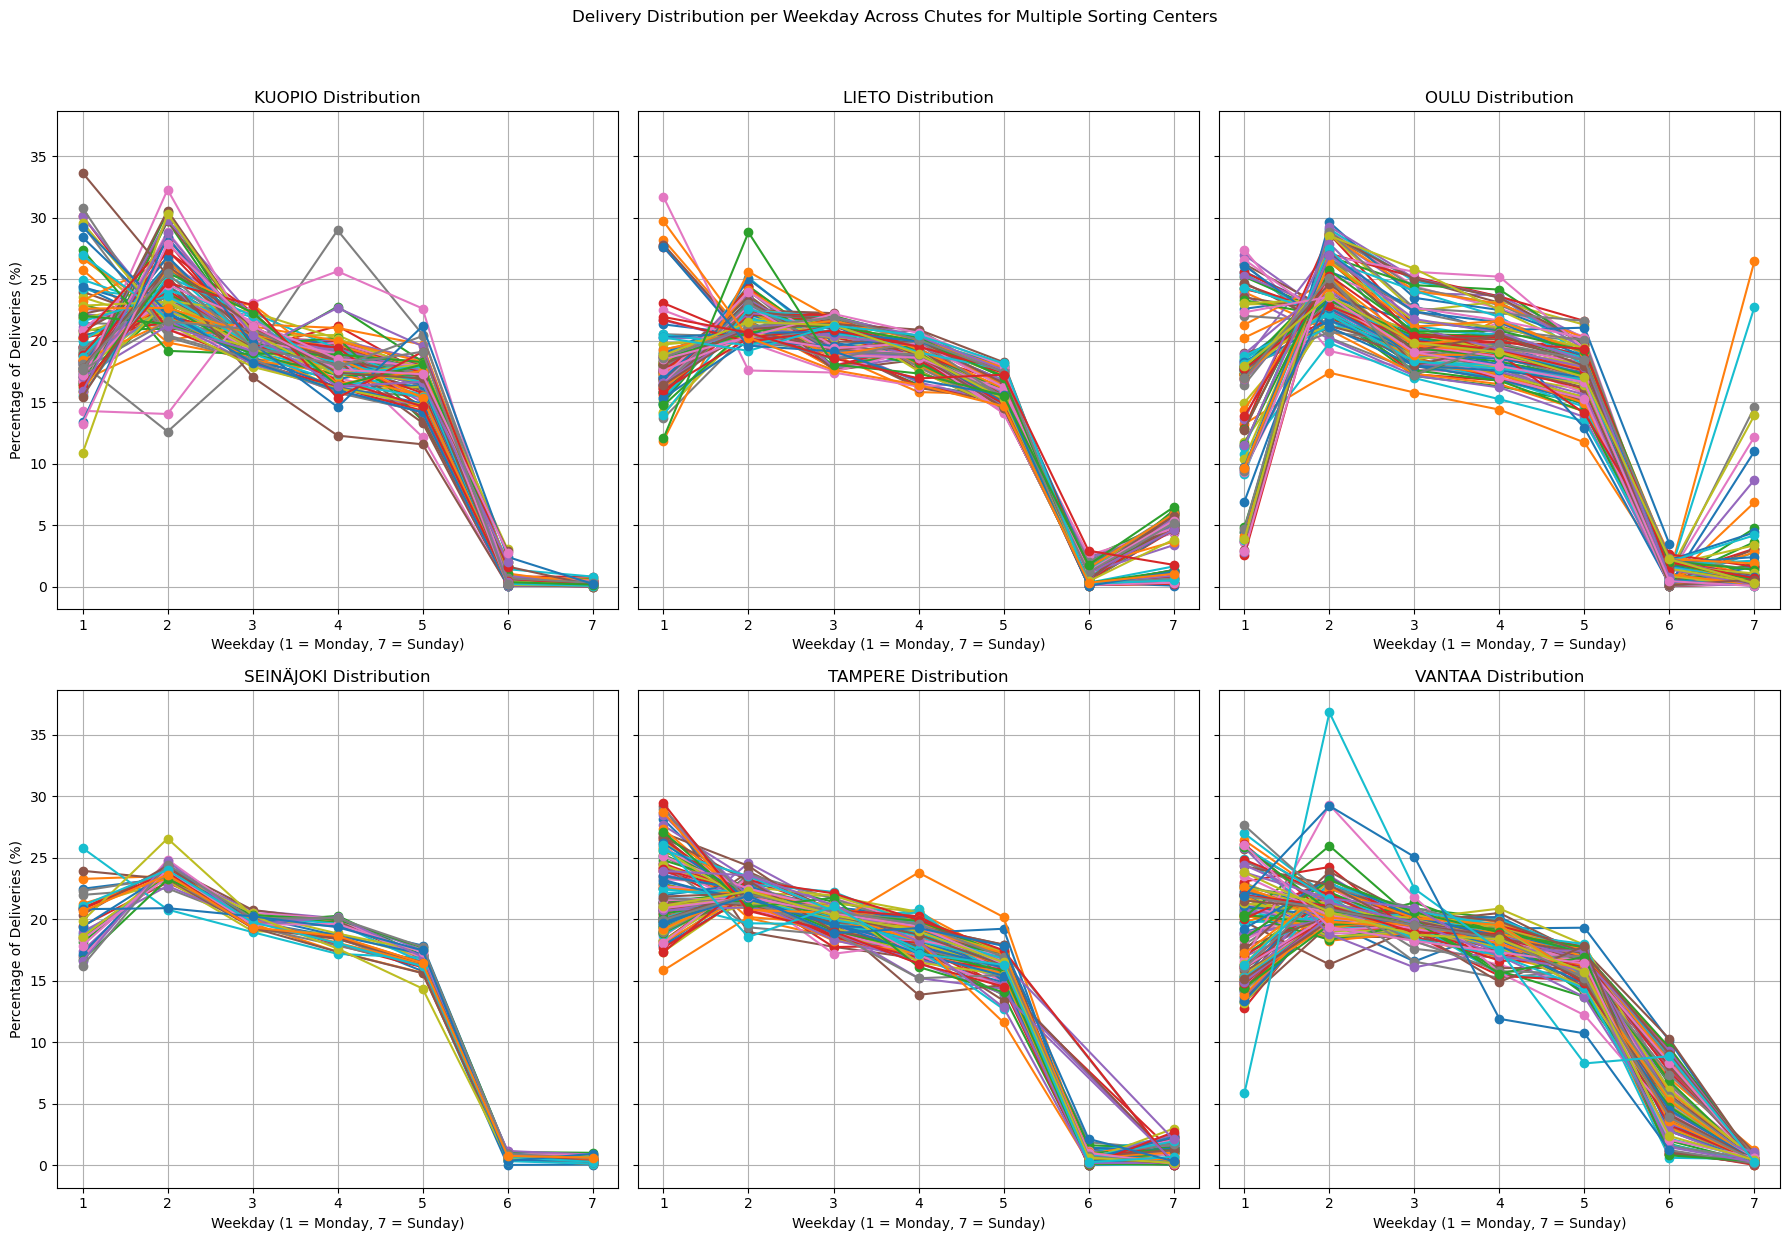

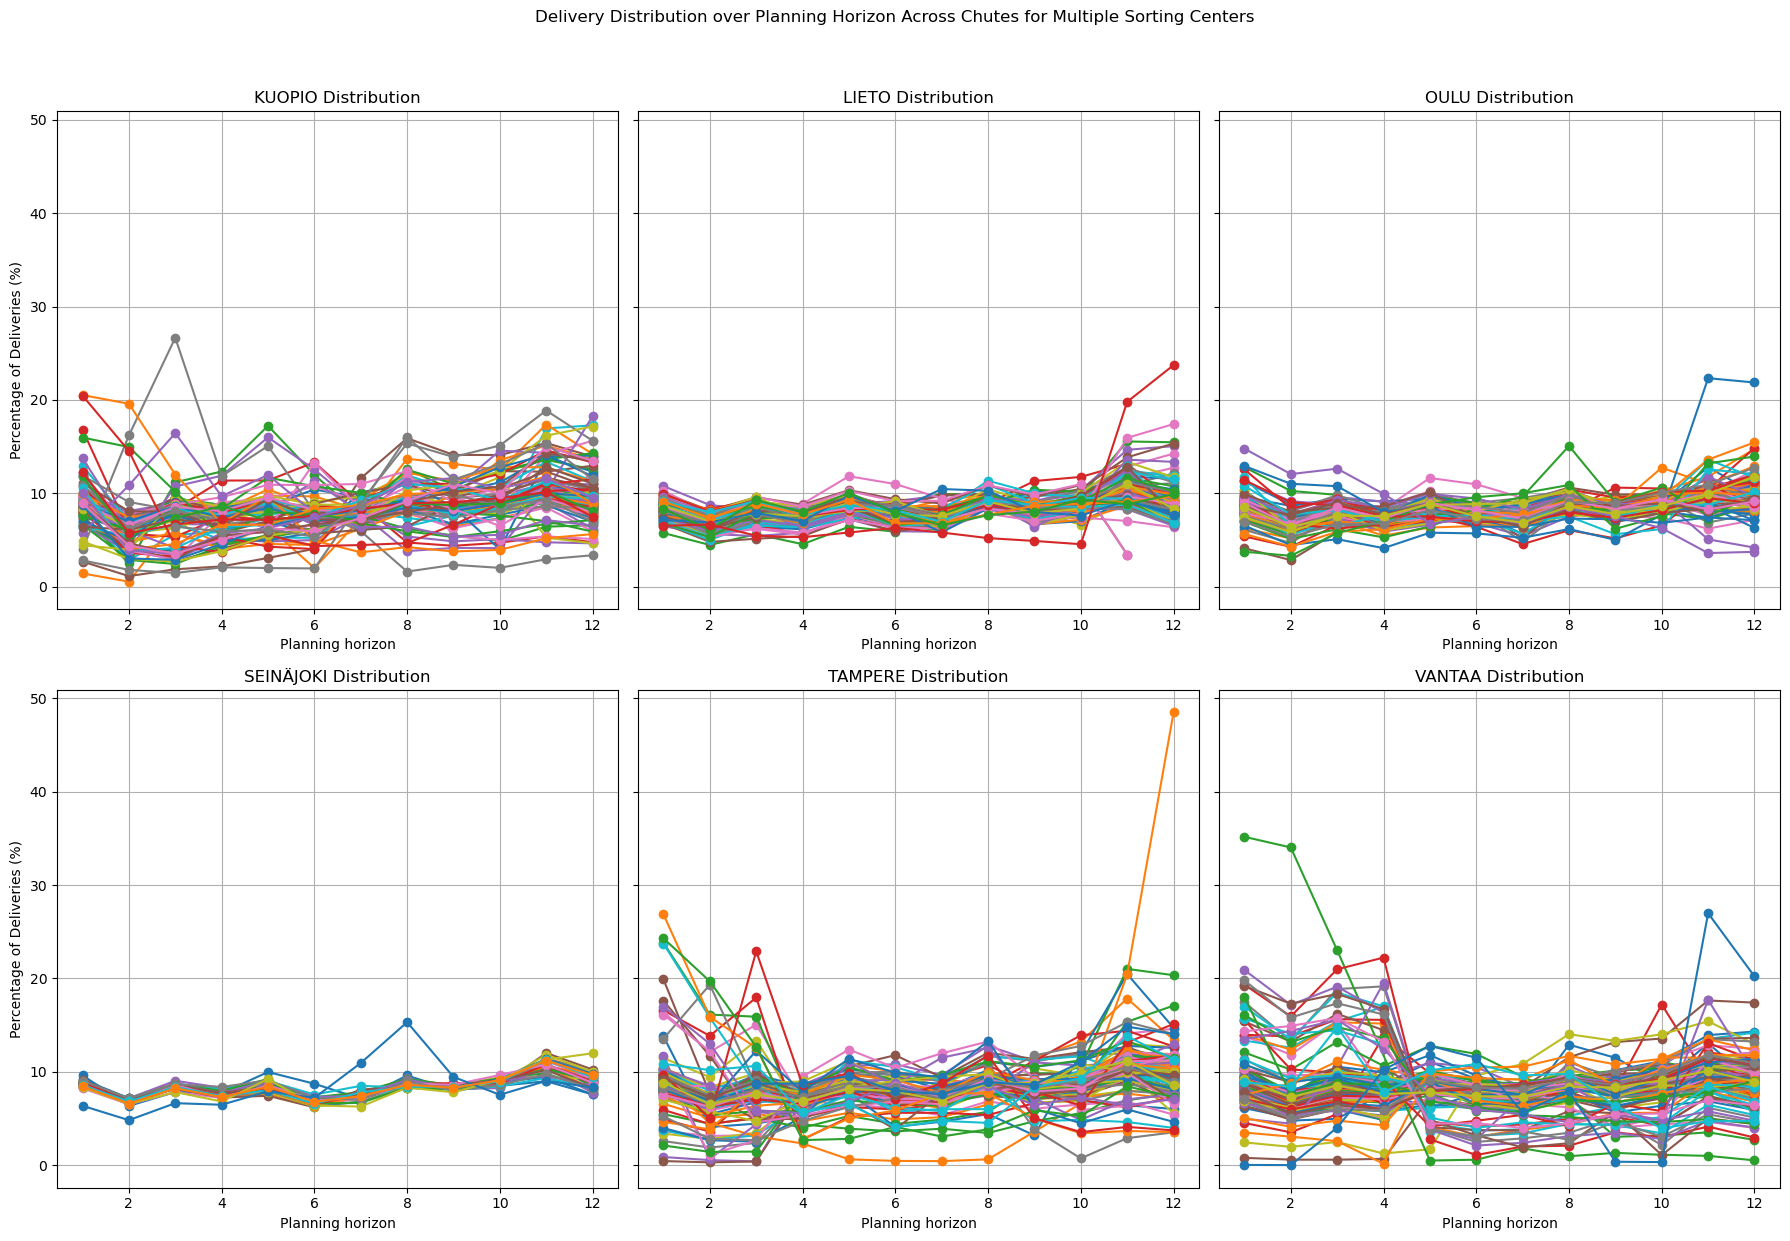

In [10]:
chute_demand_per_weekday(df, sorting_center_names)
chute_demand_planning_horizon_per_month(df, sorting_center_names)